# U-NET implementation using PyTorch

Importing libraries, and setting up the device

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
from torch import nn, Tensor
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models
from torchsummary import summary # pip install torchsummary 
import time
import os
import copy
import warnings
warnings.filterwarnings("ignore") 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Loading the data

Brain MRI images together with manual FLAIR abnormality segmentation masks.

https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation

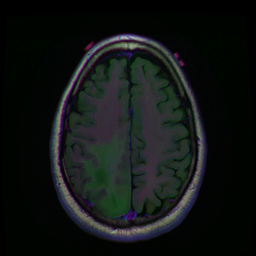

In [6]:
Image.open('archive/train/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_27.tif')

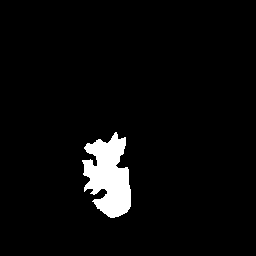

In [7]:
Image.open('archive/train/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_27_mask.tif')

### Preparing data

In this case, the data preparation only includes the division of the entire data set into training validation and test parts. The entire data set must describe reality well and all three parts must describe the entire data set well.

In [2]:
def ListImages(path):
    # We shall store all the file names in this list
    imgs = []
    targets = []

    for root, dirs, files in os.walk(path):
        for file in files:
            #append the file name to the list
            if(file.endswith("_mask.tif")):
                targets.append(os.path.join(root,file))
            else:
                if(file.endswith(".tif")):
                    imgs.append(os.path.join(root,file))

    list(sorted(imgs))
    list(sorted(targets))
    return imgs, targets

In [ ]:
path = 'archive'

imgs, targets = ListImages(path=path)
# Print all the file names
for name in imgs:
    print(name)
    
for name in targets:
    print(name)

In [10]:
path_train = 'archive/train'
path_valid = 'archive/valid'
path_test = 'archive/test'
imgs, _ = ListImages(path=path_train)
len_train =len(imgs)
print(len_train)
imgs, _ = ListImages(path=path_valid)
len_valid =len(imgs)
print(len_valid)
imgs, _ = ListImages(path=path_test)
len_test =len(imgs)
print(len_test)

4557
1358
1943


In [11]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image = t(image)
            target = t(target)
        return image, target

In [12]:
Batch_size=64;

class BrainSegmentationDataset(Dataset):
    def __init__(self, path, transforms=None):
        self.path = path
        self.transforms = transforms
        # load all image files, sorting them to ensure that they are aligned
        self.imgs = []
        self.masks = []
        for root, dirs, files in os.walk(self.path):
            for file in files:
                #append the file name to the list
                if(file.endswith("_mask.tif")):
                    self.masks.append(os.path.join(root,file))
                elif(file.endswith(".tif")):
                    self.imgs.append(os.path.join(root,file))

        self.imgs =list(sorted(self.imgs))
        self.masks =list(sorted(self.masks))
        print(len(self.imgs))
    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.imgs[idx])
        mask_path = os.path.join(self.masks[idx])
        img = Image.open(img_path)
        target = Image.open(mask_path)


        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [13]:
batch_size=32
def getdataloaders(batch_size = batch_size, path=path):
    # use the same transformations for train/valid/test
    transform = []
    transform.append(transforms.Resize(128))
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), # imagenet
    transform.append(transforms.ToTensor())
    transform = Compose(transform)
    train_set = BrainSegmentationDataset(os.path.join(path,'train'), transforms = transform)
    valid_set = BrainSegmentationDataset(os.path.join(path,'valid'), transforms = transform)
    test_set = BrainSegmentationDataset(os.path.join(path,'test'), transforms = transform)
    
    image_datasets = {
        'train': train_set, 'valid': valid_set, 'test': test_set
    }

    

    dataloaders = {
        'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
        'valid': DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=0),
        'test': DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=0)
    }

    return dataloaders

### Create a Neural network with PyTorch

The Pytorch Neural Network (https://pytorch.org/docs/stable/nn.html) model class consists of two main parts:
* Initialization - contains the layers and submodels of the model
* Foward - contains the structure of the model

Parts of a simple U-net model:
* Conv2D layer - parameters: number of inputs, outputs kernel_size, padding,...
* Activation layer
* MaxPool2d layer

In [5]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # 
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # 
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # 
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 

        # input: 
        self.e21 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # 
        self.e22 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # 
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 

        # input: 
        self.e31 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # 
        self.e32 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # 
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 

        # input: 
        self.e41 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # 
        self.e42 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # 

        # Decoder
        # In the decoder, transpose convolutional layers with the ConvTranspose2d function are used to upsample the feature maps to the original size of the input image. 
        # Each block in the decoder consists of an upsampling layer, a concatenation with the corresponding encoder feature map, and two convolutional layers.
        # -------
        self.upconv3 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(128, 64, kernel_size=3, padding=1)

        self.upconv1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(128, 64, kernel_size=3, padding=1)

        self.act=nn.ReLU()
        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = self.act(self.e11(x))
        xe12 = self.act(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = self.act(self.e21(xp1))
        xe22 = self.act(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = self.act(self.e31(xp2))
        xe32 = self.act(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = self.act(self.e41(xp3))
        xe42 = self.act(self.e42(xe41))

        
        # Decoder
        
        xu3 = self.upconv3(xe42)
        xu30 = torch.cat([xu3, xe32], dim=1)
        xd31 = self.act(self.d31(xu30))
        xd32 = self.act(self.d32(xd31))

        xu2 = self.upconv2(xd32)
        xu20 = torch.cat([xu2, xe22], dim=1)
        xd21 = self.act(self.d21(xu20))
        xd22 = self.act(self.d22(xd21))

        xu1 = self.upconv1(xd22)
        xu10 = torch.cat([xu1, xe12], dim=1)
        xd11 = self.act(self.d11(xu10))
        xd12 = self.act(self.d12(xd11))

        # Output layer
        out = self.outconv(xd12)

        return out
     

### Set up the model

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet(n_class=1).to(device)
print(model)

UNet(
  (e11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e22): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e32): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e41): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e42): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upconv3): ConvTranspose2d(128, 128, kernel_size=(2, 2), stride=(2, 2))
  (d31): Conv2d(256, 128, kernel_size=(3, 3), stride=(

### Model and its parameters

Try to check the model size with different inputs.

In [16]:
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6           [-1, 64, 64, 64]          36,928
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]          73,856
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]         147,584
             ReLU-12          [-1, 128, 32, 32]               0
           Conv2d-13          [-1, 128, 32, 32]         147,584
             ReLU-14          [-1, 128,

### Optimizers and their options

There are some pre-built optimizers in PyTorch (https://pytorch.org/docs/stable/optim.html), they are sufficient in most cases, especially if their parameters are well set. The two most well-known are ADAM and SGD, both of which originate from Gradient Descent, which we implemented earlier.

* **S**tochastic **G**radient **D**escent  - https://pytorch.org/docs/stable/generated/torch.optim.SGD.html
* **ADA**ptive **M**oment optimizer - https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
* A good general overview - https://www.ruder.io/optimizing-gradient-descent/

In [17]:
#optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9, dampening=0, weight_decay=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.99, 0.999), eps=1e-08, weight_decay=0.001)

### Loss functions and their options

Built-in cost/loss functions are also available in PyTorch (https://pytorch.org/docs/stable/nn.html#loss-functions). There are two main types: categorical and general.


Introduced by Sudre et al. in Generalised Dice overlap as a deep learning loss function for highly unbalanced segmentations(more detaile: https://arxiv.org/abs/1707.03237v3):

 $ Dice Loss = 1-\frac{2y\hat{y}+\epsilon}{y+\hat{y}+\epsilon} $
 
weighted intersection vs union with $\epsilon$ - stability and smoothness coefficient, $\hat{y}$ - prediction and $y$ - label.
We using a weighted cost function based on the Binary Cross Entropy and the Dice Loss.

In [18]:
def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

    return loss.mean()

def loss_fn(pred, target, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)


    return loss



### Dataloder and its options

The DataLoader (https://pytorch.org/docs/stable/data.html) has 3 main parameters: 
* dataset - The dataset itself
* batch_size - Number of evaluations used for an optimization step
* shuffle - Regenerates batches in every epoch (cannot be used in the case of time series data)

In [19]:
dataloaders = getdataloaders()

4557
1358
1943


## Training

Training and testing a model always consists of 3 parts:
* Training - only the training data set is used, and the weights are updated based on this
* Validation - the validation data set is used, indirectly participates in training and serves to monitor the training process
* Testing - the test data set is used, it does not participate in training in any way, and the goal is independent testing

In [20]:
n_epochs = 5
hist_train=[];
hist_valid=[];
best_loss=float('inf')
best_model_wts = copy.deepcopy(model.state_dict())
early_stop_tolerant_count=0
early_stop_tolerant=10;
for epoch in range(n_epochs):
    # Training
    model.train()
    phase="train"
    for X_batch, y_batch in dataloaders[phase]:
        
        y_pred = model(X_batch.to(device))
        train_loss = loss_fn(y_pred, y_batch.to(device))
        train_loss=train_loss/batch_size
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    # Validation
    # model.eval()
    with torch.no_grad():
        valid_loss=0
        phase="valid"
        for X_batch, y_batch in dataloaders[phase]:
            y_pred = model(X_batch.to(device))
            valid_loss = valid_loss+torch.sqrt(loss_fn(y_pred, y_batch.to(device)))
        valid_loss=valid_loss/len_valid                        
        hist_train.append(np.array(train_loss.cpu().detach()))
        hist_valid.append(np.array(valid_loss.cpu().detach()))
        
    # Always save the current best model based on the validation data, and stop the training if no improvements happen after a certain epoch.    
    early_stop_tolerant_count=early_stop_tolerant_count+1
    if valid_loss < best_loss:
        early_stop_tolerant_count=0
        best_loss = valid_loss
        best_model_wts = copy.deepcopy(model.state_dict())
    if early_stop_tolerant_count>=early_stop_tolerant:
        break 
    if epoch % 1 != 0:
        continue       
    # Display some information along the training
    print("Epoch %.4d: train loss %.2f, valid loss %.2f" % (epoch, train_loss, valid_loss))

model.eval()

Epoch 0000: train loss 0.01, valid loss 0.01
Epoch 0001: train loss 0.01, valid loss 0.01
Epoch 0002: train loss 0.01, valid loss 0.01
Epoch 0003: train loss 0.00, valid loss 0.01
Epoch 0004: train loss 0.01, valid loss 0.01


UNet(
  (e11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e22): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e32): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e41): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e42): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upconv3): ConvTranspose2d(128, 128, kernel_size=(2, 2), stride=(2, 2))
  (d31): Conv2d(256, 128, kernel_size=(3, 3), stride=(

### Testing

In [21]:
import pickle

# Serializing the object to a file
with open('best_model_wts.pkl', 'wb') as file:
    pickle.dump(best_model_wts, file)

In [3]:
# in case of Python kernel panic

import pickle

with open('best_model_wts.pkl', 'rb') as file:
    best_model_wts = pickle.load(file)

In [7]:
#Test 
torch.cuda.empty_cache()
model.load_state_dict(best_model_wts)
model.eval()
test_loss=0
phase="test"
for X_batch, y_batch in dataloaders[phase]:
    y_pred = model(X_batch.to(device))
    test_loss = test_loss+torch.sqrt(loss_fn(y_pred, y_batch.to(device)))
test_loss=test_loss/len_test

print("Final epoch %d: train loss %.2f, valid loss %.2f, test loss %.2f" % (epoch, train_loss, valid_loss, test_loss))

NameError: name 'dataloaders' is not defined

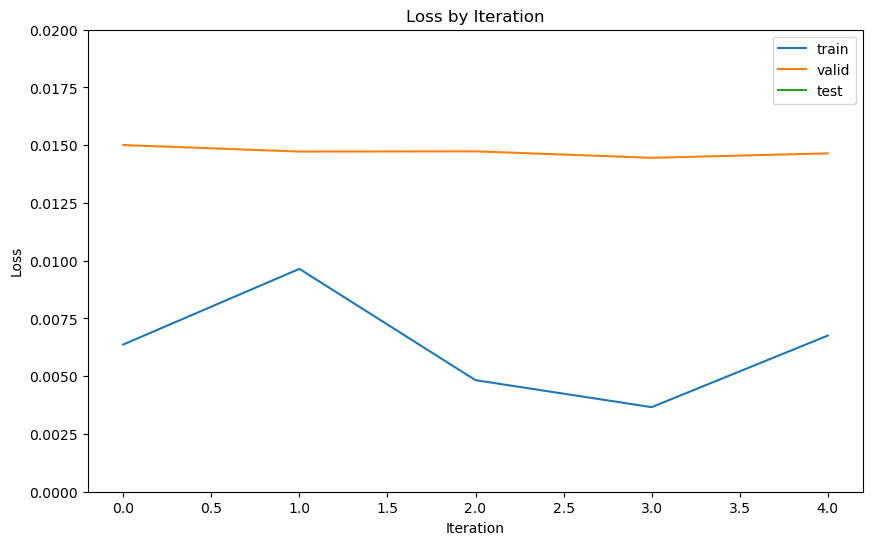

In [ ]:
%matplotlib inline 
plt.figure(figsize=(10,6))
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss by Iteration')
plt.plot(hist_train)
plt.plot(hist_valid)
plt.plot(test_loss.cpu().detach().numpy()*np.ones(len(hist_valid)))
plt.ylim((0,0.020))
plt.legend(['train', 'valid', 'test'])

### Prediction
Let's see what the prediction looks like.

In [ ]:
y_pred

tensor([[[[ -6.6144, -10.5490, -11.9676,  ..., -11.9675, -10.5444,  -6.6134],
          [-10.5461, -16.9657, -19.2928,  ..., -19.2869, -16.9524, -10.5427],
          [-11.9501, -19.2687, -21.9261,  ..., -21.8995, -19.2336, -11.9343],
          ...,
          [-11.9400, -19.2469, -21.8923,  ..., -21.8282, -19.1908, -11.9162],
          [-10.5433, -16.9576, -19.2742,  ..., -19.2363, -16.9257, -10.5339],
          [ -6.6361, -10.5854, -12.0038,  ..., -11.9878, -10.5733,  -6.6364]]],


        [[[ -6.6143, -10.5489, -11.9690,  ..., -11.9667, -10.5445,  -6.6135],
          [-10.5459, -16.9651, -19.2948,  ..., -19.2868, -16.9531, -10.5433],
          [-11.9496, -19.2675, -21.9261,  ..., -21.9040, -19.2377, -11.9367],
          ...,
          [-11.9532, -19.2789, -21.9441,  ..., -21.8457, -19.2046, -11.9230],
          [-10.5541, -16.9832, -19.3165,  ..., -19.2402, -16.9273, -10.5342],
          [ -6.6421, -10.5995, -12.0278,  ..., -11.9867, -10.5711,  -6.6347]]],


        [[[ -6.6164, -10.5

In [ ]:
y_pred.size()

torch.Size([32, 1, 128, 128])

### Example images

In [ ]:
trans = torchvision.transforms.ToPILImage()
out = trans(y_pred[0])
out.show()

In [ ]:
trans = torchvision.transforms.ToPILImage()
out = trans(X_batch[0])
out.show()